# Evaluation of Analyzers using Input Perturbations
This notebook will guide you through an example how to evaluate analyzers via perturbing the input according to the importance that the different input dimensions have.

In particular, several analyzers will be applied to a simple multi-layer perceptron trained on MNIST digits, namely:
* Sensitivity Analysis
* Deconvolution
* Layer-wise relevance propagation

The input pixels are divided into quadratic regions that **sorted according to their importance** assigned by those analyzers. Then, the **information in the most important regions is destroyed** by perturbating them and the effect of the perturbation on the classifier performance is measured. This procedure is repeated several times.

We expect that the classifier performance drops quickly if important information is removed. Thus, different analyzers can be evaluated by looking at how quickly the performance drops, i.e. the better the analyzer finds the relevant regions in the image the quicker the performance should deteriorate.

As a reference, see: **Samek, Wojciech, et al.** "Evaluating the visualization of what a deep neural network has learned." *IEEE transactions on neural networks and learning systems* 28.11 (2017): 2660-2673.

# Prepare the model, analyzers and data

In [1]:
import imp
import keras.backend
import keras.models
import matplotlib.pyplot as plt
import numpy as np
import os

import keras
from keras.datasets import mnist
from keras.models import Model
from keras.optimizers import RMSprop

import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.tests.networks.base
import innvestigate.utils.visualizations as ivis

from innvestigate.tools import Perturbation, PerturbationAnalysis

base_dir = ".."
eutils = imp.load_source("utils", os.path.join(base_dir, "utils.py"))
mnistutils = imp.load_source("utils_mnist", os.path.join(base_dir, "utils_mnist.py"))

keras.backend.set_image_data_format("channels_first")

Using TensorFlow backend.


### Define helper functions

In [2]:
def fetch_data():
    # the data, shuffled and split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.reshape(60000, 1, 28, 28)
    x_test = x_test.reshape(10000, 1, 28, 28)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    # TODO Comment this out if you want to test it on a small subset of the data
    #x_train, y_train, x_test, y_test = x_train[:100], y_train[:100], x_test[:100], y_test[:100]

    return x_train, y_train, x_test, y_test


def create_model():
    num_classes = 10

    network = innvestigate.utils.tests.networks.base.mlp_2dense(
        (None, 1, 28, 28),
        num_classes,
        dense_units=1024,
        dropout_rate=0.25)
    model_wo_sm = Model(inputs=network["in"], outputs=network["out"])
    model_w_sm = Model(inputs=network["in"], outputs=network["sm_out"])
    return model_wo_sm, model_w_sm


def train_model(model, data):
    batch_size = 128
    num_classes = 10
    epochs = 5

    x_train, y_train, x_test, y_test = data
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])
    
    weights_file = "model_with_softmax.h5"
    if os.path.exists(weights_file):
        print("Loading weights from file.")
        model.load_weights(weights_file)
    else:
        model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1)
        model.save_weights(weights_file)
        
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

def preprocess(X, zero_mean=False):
    X.copy()
    X /= 255.0
    if zero_mean:
        X -= 0.5
    return X

### Load data

In [3]:
num_classes = 10
batch_size = 256
data = fetch_data()
data_preprocessed = (preprocess(data[0]), data[1],
                         preprocess(data[2]), data[3])
x_test, y_test = data_preprocessed[2:]
y_test = keras.utils.to_categorical(y_test, num_classes)
test_sample = np.copy(x_test[0:1])
generator = iutils.BatchSequence([x_test, y_test], batch_size=batch_size)

60000 train samples
10000 test samples


### Build and train the model

In [4]:
model_without_softmax, model_with_softmax = create_model()
train_model(model_with_softmax, data_preprocessed)
model_without_softmax.set_weights(model_with_softmax.get_weights())

Loading weights from file.
Test loss: 0.06824304887162289
Test accuracy: 0.9809


# Perturbation Analysis

### Setup analyzer and perturbation
The perturbation analysis takes several parameters:
* `perturbation_function`: This is the method with which the pixels in the most important regions are perturbated. You can pass your own function or pass a string to select one of the predefined functions, e.g. "zeros", "mean" or "gaussian".
* `region_shape`: The shape of the regions that are considered for perturbation. In this case, we use single pixels. Regions are aggregated ("pooled") using a (customizable) aggregation function that is average pooling by default. The input image is padded such that it can be subdivided into an integer number of regions.
* `steps`: Number of perturbation steps. 
* `ratio`: In each perturbation step, the `ratio` * 100% most important pixels are perturbed.

In [5]:
perturbation_function = np.zeros_like  # Equivalently, we could provide the string "zeros"
region_shape  = (1, 1) 
steps = 5
ratio = 0.01  # Perturbate 1% of pixels per perturbation step

methods = {
    "gradient": ("gradient",    {}, mnistutils.graymap, "Gradient"),
    "deconvnet": ("deconvnet",   {}, mnistutils.bk_proj, "Deconvnet"),
    "lrp.epsilon": ("lrp.epsilon", {}, mnistutils.heatmap, "LRP Epsilon"),
}

# Select a method of your choice
method = methods["lrp.epsilon"]

analyzer = innvestigate.create_analyzer(method[0],
                                        model_without_softmax,
                                        **method[1])

### Setup perturbation
The perturbation analysis consists of two parts:
1. An object of the class `Perturbation` that performs the actual perturbation of input images. Here, we use (1, 1)-regions (i.e. single pixels) and add Gaussian noise to the original values of the most important pixels.
2. An object of the class `PerturbationAnalysis` that computes the analysis, performes several perturbation steps and evaluates the model performance. In each step, the 5% most important pixels are perturbed.

In [6]:
perturbation = Perturbation(perturbation_function, region_shape=region_shape, in_place=True)
perturbation_analysis = PerturbationAnalysis(analyzer, model_with_softmax, generator, perturbation,
                                                 steps=steps, ratio=ratio)

## Evaluate the model after several perturbation steps

In [7]:
scores = perturbation_analysis.compute_perturbation_analysis()

Step 1
Step 2
Step 3
Step 4
Step 5


Scores:
[[0.06824305 0.9809    ]
 [0.48152562 0.8462    ]
 [2.81870714 0.3902    ]
 [4.1168086  0.186     ]
 [4.32407767 0.1412    ]
 [3.81228671 0.1375    ]]


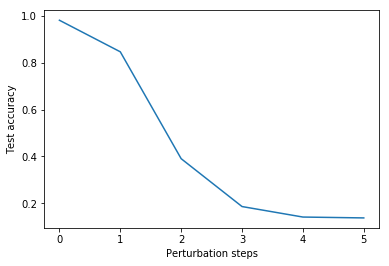

In [8]:
scores = np.array(scores)
print("Scores:")
print(scores)
plt.plot(scores[:, 1])
plt.xlabel("Perturbation steps")
plt.ylabel("Test accuracy")
plt.xticks(np.array(range(scores.shape[0])))
plt.show()

## 2. Plot perturbed sample

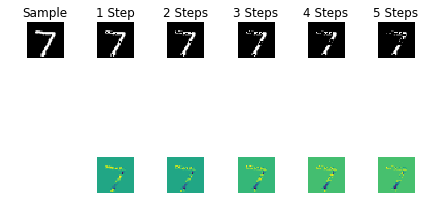

In [9]:
steps = 5

plt.figure()
plt.subplot(2, steps + 1, 1)
plt.imshow(np.squeeze(test_sample), cmap="Greys_r")
plt.axis("off")
plt.title("Sample")

for i in range(steps):
    test_sample, analysis = perturbation_analysis.compute_on_batch(test_sample, return_analysis=True)
    
    plt.subplot(2, steps + 1, i + 2)
    plt.imshow(np.squeeze(test_sample), cmap="Greys_r")
    plt.title("{} Step{}".format(i + 1, "" if i == 0 else "s"))
    plt.axis("off")
    
    plt.subplot(2, steps + 1, i + 2 + (steps + 1))
    plt.imshow(np.squeeze(analysis))
    plt.axis("off")
plt.tight_layout()  # Takes care of spaces between subfigures
plt.show()